In [1]:
#!pip install setuptools==67.0.0
#!pip install .
#!pip install rasterio
#!pip install opencv-python

In [2]:
import os
import cv2
import math
import boto3
import torch
import shutil
import random
import rasterio
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.io import imread

In [3]:
image_list = []

bucket_region_name = 'eu-west-2'

folderpath_p = "orbital-ai/Phisat/BurntArea/global/TestFolder/"
s3 = boto3.client('s3', region_name = bucket_region_name)
bucket_name ='datasets-open'
bucket = s3.list_objects(Bucket = bucket_name, Prefix = "orbital-ai/Phisat/BurntArea/global/TestFolder/")
for obj in bucket['Contents']:
    image_list.append(obj['Key'])

image_list.pop(0)
print(len(image_list))

4


In [4]:
mean = 0.14014238119125366
std = 0.09054151177406311

In [5]:
preprocessed_image_files = []

for image_file in tqdm(image_list, total=len(image_list), desc='Processing Images'):
    images_file = "s3://datasets-open/" + image_file
    
    with rasterio.open(images_file) as image_src:
        bands_to_read = [1,2,3,5,6,7,8]
        image = image_src.read(bands_to_read)
        image = np.transpose(image)
        image = (image - mean) / std
        image = 1 / (1 + np.exp(-image))
        preprocessed_image_files.append(image)
               
preprocessed_image_array = np.array(preprocessed_image_files, dtype=object)

Processing Images: 100%|██████████| 4/4 [02:14<00:00, 33.60s/it]


In [6]:
def slice_and_pad_images(image, tile_size, stride):
    padded_images = []

    rows, cols, channels = image.shape
    mask_size = rows * cols
    total_tiles = 0

    num_tiles = math.ceil(rows / tile_size) * math.ceil(cols / tile_size)
    total_tiles += num_tiles

    if rows >= tile_size and cols >= tile_size:
        for y in range(0, rows, stride):
            for x in range(0, cols, stride):

                tile_start_y = min(tile_size, (rows - y))
                tile_start_x = min(tile_size, (cols - x))

                start_y = y - (tile_size - tile_start_y)
                start_x = x - (tile_size - tile_start_x)

                tile_image = image[start_y:start_y + tile_size, start_x:start_x + tile_size, :]          

                padded_images.append(tile_image)

    return padded_images  

In [7]:
def stitch_tf_tiles(padded_images, original_image_shape, tile_size, stride):
    rows, cols,_ = original_image_shape
    num_rows = (rows - 1) // stride + 1
    num_cols = (cols - 1) // stride + 1
    channels = padded_images[0].shape[-1]
    
    stitched_image = np.zeros((rows, cols, channels), dtype=np.float32)
    stitched_count = np.zeros((rows, cols), dtype=np.float32)
    one = np.ones_like(padded_images[0][:,:,0])
    
    tile_count = 0

    for iy in range(0, num_rows):
        start_y = iy * stride
        end_y = start_y + tile_size
        if end_y > rows:
            end_y = rows
            start_y = rows - tile_size

        for ix in range(num_cols):
            start_x = ix * stride
            end_x = start_x + tile_size
            if end_x > cols:
                end_x = cols
                start_x = cols - tile_size

            tile_image = padded_images[tile_count]
            stitched_image[start_y:end_y, start_x:end_x, :] += tile_image
            stitched_count[start_y:end_y, start_x:end_x] += one
            tile_count += 1


    #stitched_image /= stitched_count
    for c in range(channels):
        stitched_image[:, :, c] /= stitched_count

    return stitched_image

In [ ]:
def stitch_tiles(padded_images, original_image_shape, tile_size, stride):
    rows, cols = original_image_shape[:2]
    channels = 1  # Since this is single-channel data
    num_rows = (rows - 1) // stride + 1
    num_cols = (cols - 1) // stride + 1
    
    stitched_image = np.zeros((rows, cols), dtype=np.float32)
    stitched_count = np.zeros((rows, cols), dtype=np.float32)
    one = np.ones((tile_size, tile_size), dtype=np.float32)
    
    tile_count = 0

    for iy in range(num_rows):
        start_y = iy * stride
        end_y = start_y + tile_size
        if end_y > rows:
            end_y = rows
            start_y = rows - tile_size

        for ix in range(num_cols):
            start_x = ix * stride
            end_x = start_x + tile_size
            if end_x > cols:
                end_x = cols
                start_x = cols - tile_size

            tile_image = padded_images[tile_count]

            # Adding weighted sum for overlap smoothing
            stitched_image[start_y:end_y, start_x:end_x] += tile_image[:end_y-start_y, :end_x-start_x]
            stitched_count[start_y:end_y, start_x:end_x] += one[:end_y-start_y, :end_x-start_x]
            tile_count += 1

    # Normalize the stitched image by the stitch count to smooth overlaps
    stitched_image /= stitched_count

    return stitched_image

In [8]:
images_list = []
for file in preprocessed_image_files:
    images = slice_and_pad_images(file, tile_size = 256, stride= 256)
    images_list.append(images)
    
print(len(images_list[0]))

256


In [9]:
# Load and prepare the model
loaded_model = torch.load('Models/model-5.pt')
loaded_model = loaded_model.cuda()
loaded_model.eval()

# Iterate over each set of image tiles
predicted_tiles_list = []

for image_tiles in tqdm(images_list, desc='Predicting on Tiles'):
    predicted_tiles = []
    
    for tile in image_tiles:
        # Convert the tile to a tensor and add batch dimension
        tile_tensor = torch.tensor(tile).float().permute(2, 0, 1).unsqueeze(0).cuda()  # Assuming GPU usage
        
        # Model prediction
        with torch.no_grad():
            logits = loaded_model(tile_tensor)
            #print(f"Logits shape: {logits.shape}")
            #print(f"Logits data type: {logits.dtype}")
            #print(f"Logits first channel value range: min={logits[0, 0, :, :].min().item()}, max={logits[0, 0, :, :].max().item()}")
            
            # Apply softmax to get probabilities
            probabilities = F.softmax(logits, dim=1)
            #print(f"Probabilities shape after softmax: {probabilities.shape}")
            #print(f"Probabilities data type: {probabilities.dtype}")
            #print(f"Probabilities first channel value range: min={probabilities[0, 0, :, :].min().item()}, max={probabilities[0, 0, :, :].max().item()}")
            
            # Get the predicted class by using argmax
            prediction = torch.argmax(probabilities, dim=1)  # Should result in shape [batch_size, height, width]
            #print(f"Prediction shape after argmax: {prediction.shape}")
            #print(f"Prediction data type: {prediction.dtype}")
            #print(f"Prediction unique values: {torch.unique(prediction[0])}")  # Assuming only one image in the batch
        
        # Remove the batch dimension and convert back to numpy
        prediction = prediction.squeeze(0).cpu().numpy()
        
        # Append the prediction to the list of predicted tiles
        predicted_tiles.append(prediction)
    
    predicted_tiles_list.append(predicted_tiles)


/tmp/ipykernel_24680/24825206.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('Models/model-5.pt')
Predicting on Tiles: 100%|██████████| 4/4 [0

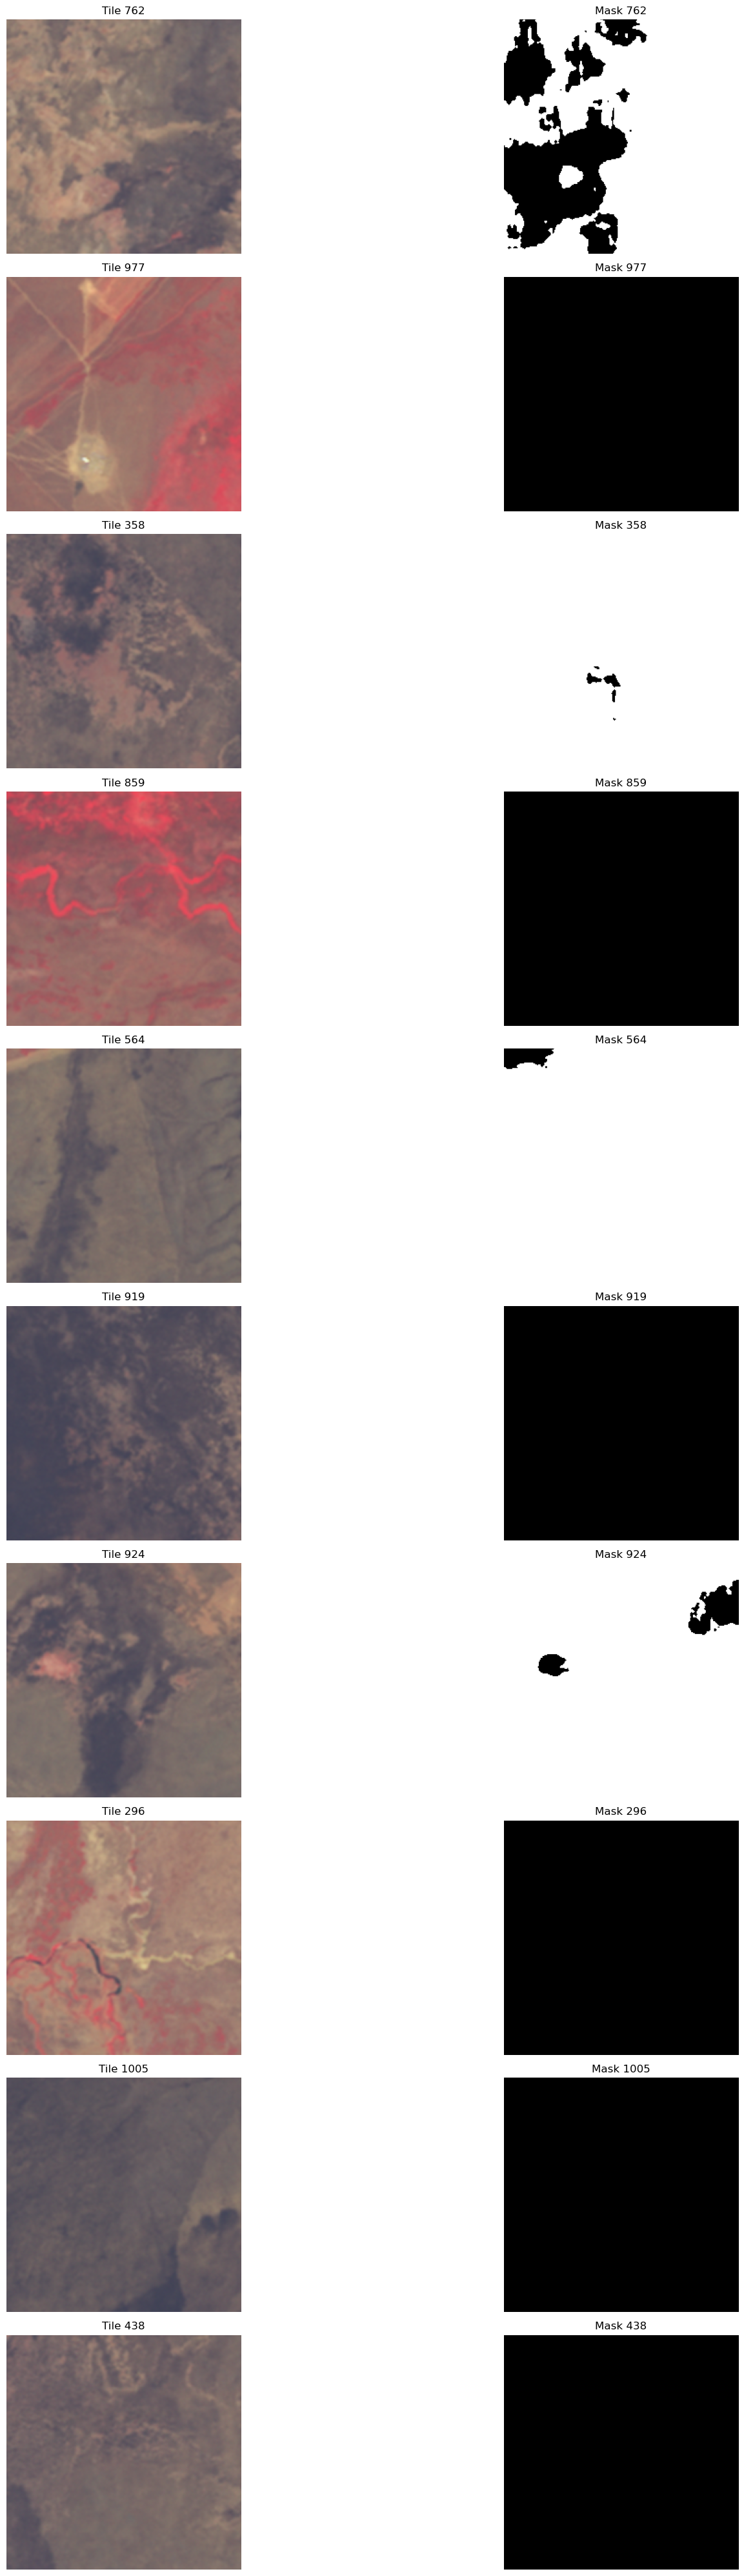

In [12]:
# Set up the number of tiles to display
num_tiles_to_display = 10

# Flatten the list of lists to make it easier to sample randomly
flattened_images = [tile for sublist in images_list for tile in sublist]
flattened_predictions = [tile for sublist in predicted_tiles_list for tile in sublist]

# Sample 10 random tiles and their corresponding masks
random_indices = random.sample(range(len(flattened_images)), num_tiles_to_display)

# Plotting the tiles and their masks
plt.figure(figsize=(20, 40))  # Increase figure size for larger images

for i, idx in enumerate(random_indices):
    # Select channels 4, 3, and 1 for RGB-like display
    selected_channels = flattened_images[idx][:, :, [3, 2, 0]]
    
    # Original tile
    plt.subplot(num_tiles_to_display, 2, 2 * i + 1)
    plt.imshow(selected_channels)
    plt.title(f"Tile {idx+1}")
    plt.axis('off')
    
    # Corresponding output mask
    plt.subplot(num_tiles_to_display, 2, 2 * i + 2)
    plt.imshow(flattened_predictions[idx], cmap='gray')
    plt.title(f"Mask {idx+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Stitch the predicted tiles back together
stitched_images = []

print(len(predicted_tiles_list))
for i, predicted_tiles in enumerate(predicted_tiles_list):
    stitched_image = stitch_tiles(predicted_tiles, preprocessed_image_files[i].shape, tile_size=256, stride=256)
    stitched_images.append(stitched_image)


4


Image: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


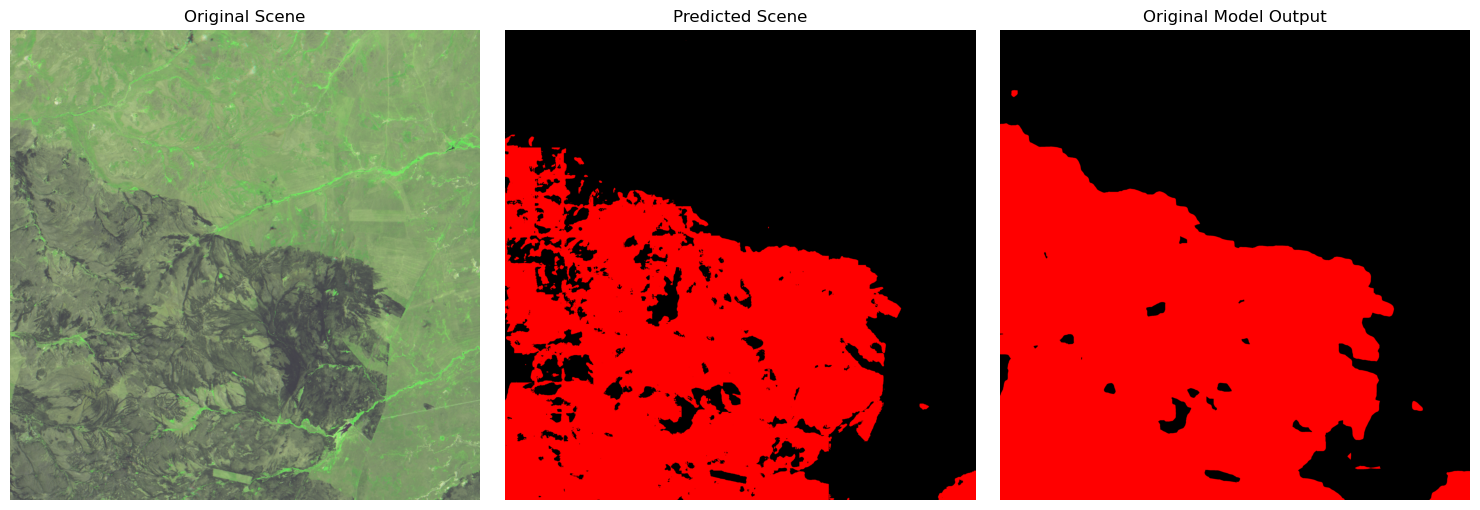

Image: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


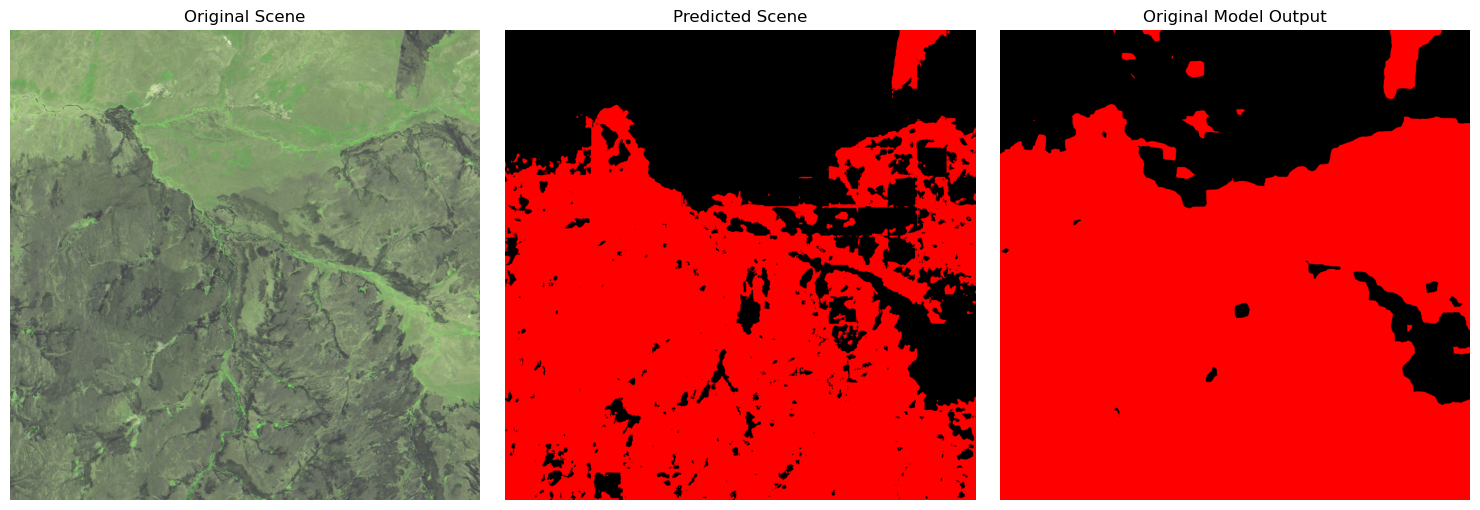

Image: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


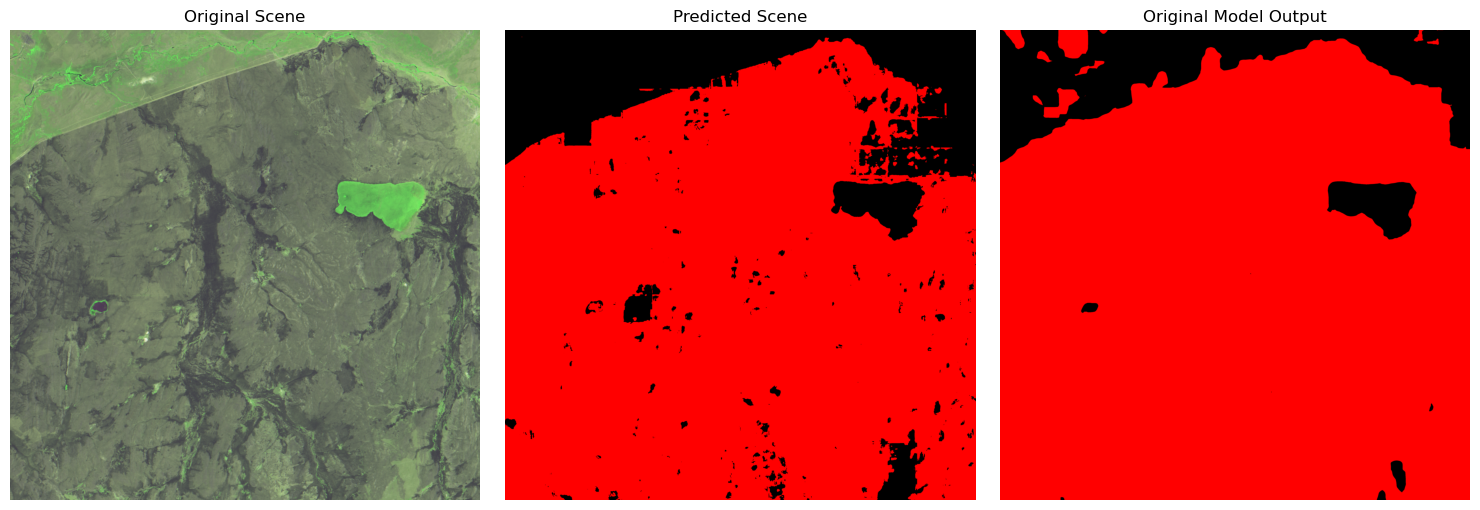

Image: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


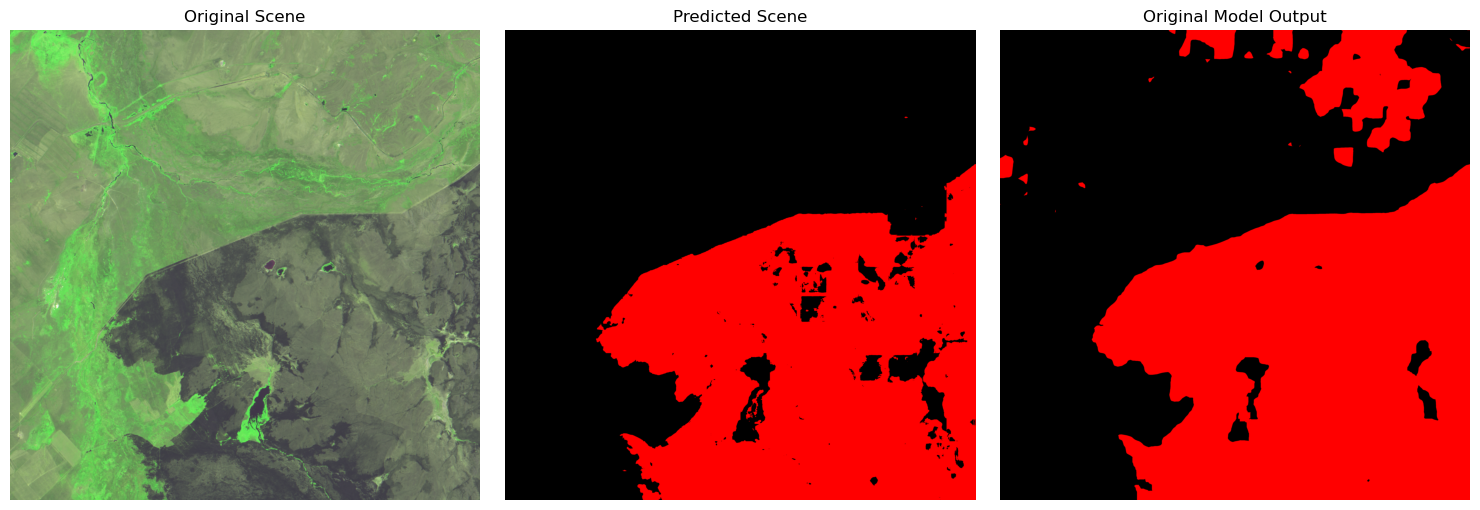

In [17]:
# Define colormap
colormap = {
    0: [0, 0, 0],       # Class 0 (black) = no class
    1: [255, 0, 0],     # Class 1 (red) = Burnt Area
    2: [0, 255, 0],     # Class 2 (green) = Clouds
    3: [0, 0, 255]      # Class 3 (blue) = Water bodies
}

# Directory containing the original model outputs
original_outputs_dir = 'Original-Outputs/'

for i, (imgs, predictions) in enumerate(zip(preprocessed_image_array, stitched_images)):
    # Ensure imgs is a numeric array
    imgs = np.array(imgs, dtype=np.float32)

    # Create the RGB image using channels 4, 3, 1 from the original image (assuming they are RGB)
    rgb_img = np.stack((imgs[:, :, 4], imgs[:, :, 3], imgs[:, :, 1]), axis=-1)

    # Convert rgb_img to uint8 if necessary (assuming the range is 0-1 for float32)
    rgb_img = (rgb_img * 255).astype(np.uint8)

    rgb_prediction = np.zeros((predictions.shape[0], predictions.shape[1], 3), dtype=np.uint8)

    for class_label in np.unique(predictions):
        if class_label in colormap:  
            mask = predictions == class_label
            rgb_prediction[mask] = colormap[class_label]

    original_output_path = os.path.join(original_outputs_dir, f'Original_output-{i+1}.tif')
    original_output_img = imread(original_output_path)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    print(f"Image: {i+1}")
    axes[0].imshow(rgb_img)
    axes[0].set_title('Original Scene')
    axes[0].axis('off')

    axes[1].imshow(rgb_prediction)
    axes[1].set_title('Predicted Scene')
    axes[1].axis('off')

    axes[2].imshow(original_output_img)
    axes[2].set_title('Original Model Output')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
